## Домашнее задание №7
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Авторы: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), Горохов Олег

Ваша основная задача: научиться генерировать стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [ ]:
# Не меняйте блок кода ниже! Здесь указаны все необходимые import-ы
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [ ]:
# Не меняйте блок кода ниже!
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [ ]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/onegin_hw07.txt -O ./onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text]) # Убираем лишние символы табуляций, приводим все буквы к нижнему регистру
# __________end of block__________

--2023-12-02 20:38:41--  https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/onegin_hw07.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘./onegin.txt’

./onegin.txt        100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2023-12-02 20:38:42 (11.1 MB/s) - ‘./onegin.txt’ saved [262521/262521]



Выведем несколько первых символов входного текста. Видим, что символы табуляций удалены, буквы приведены к нижнему регистру. Символы \n мы оставляем - чтобы научить сеть генерировать символ \n, когда нужно перейти на новую строку.

In [ ]:
text[:36]

'\ni\n\n«мой дядя самых честных правил,\n'

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим технический токен `<sos>`.

In [ ]:
# Не меняйте блок кода ниже!
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>'] # Строим множество всех токенов-символов и добавляем к нему служебный токен <sos>
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)} # Строим словарь с ключами-токенами и значениями-индексами в списке токенов
idx_to_token = {idx: x for idx, x in enumerate(tokens)} # Строим обратный словарь (чтобы по индексу можно было получить токен)

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятия №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [ ]:
# Не меняйте код ниже
# __________start of block__________
batch_size = 256 # Размер батча. Батч - это набор последовательностей символов.
seq_length = 100 # Максимальная длина одной последовательности символов в батче
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>'] # Добавляем в начало каждой строки технический символ - для определения начального состояния сети

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1) # Случайным образом выбираем индекс начального символа в батче
    # Строим непрерывный батч.
    # Для этого выбираем в исходном тексте подпоследовательность, которая начинается с индекса start_index и имеет размер batch_size*seq_length.
    # Затем мы делим эту подпоследовательность на batch_size последовательностей размера seq_length. Это и будет батч, матрица размера batch_size*seq_length.
    # В каждой строке матрицы будут указаны индексы
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [ ]:
next(generate_chunk())

array([[83, 59, 48, ..., 45, 56,  1],
       [83, 62, 50, ...,  1, 62, 63],
       [83, 59, 56, ..., 59, 63, 59],
       ...,
       [83, 50, 14, ..., 58, 76, 63],
       [83, 58, 45, ..., 40, 38, 26],
       [83,  0,  0, ..., 45, 63, 73]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits

In [ ]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss()

In [ ]:
batch_ix = next(generate_chunk())
batch_ix = torch.LongTensor(batch_ix)

logits = model(batch_ix)

In [ ]:
logits.shape

torch.Size([256, 101, 84])

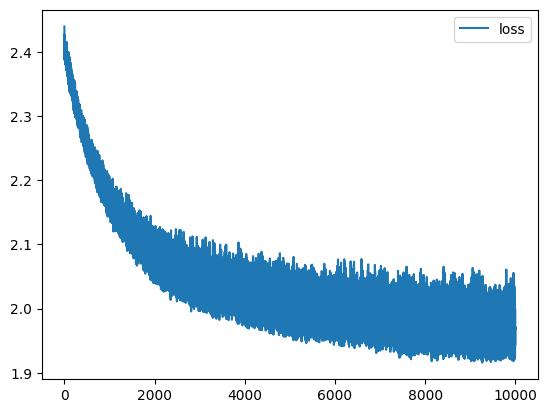

In [ ]:
MAX_LENGTH = 16
history = []

for i in range(10000):                                                             # всего 1000 итераций

    batch_ix = next(generate_chunk())
    batch_ix = torch.LongTensor(batch_ix)

    logits = model(batch_ix)                                                   # получили последовательность logp

    # Считаем loss
    predictions_logp = F.log_softmax(logits[:, :-1], dim=-1)
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    # Обучение методов backprop
    loss.backward()                                                               # посчитали градиенты
    opt.step()
    opt.zero_grad()                                                                  # сделали шаг

    # код отрисовки графика
    history.append(loss.item())
    if (i+1)%100==0:                                                              # на каждом сотом шаге обновляем график
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."     # проверяем, что среднее значение за последние 10 шагов больше
                                                                                  # среднего значения за первые 10 шагов (если нет – модель не сошлась)

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

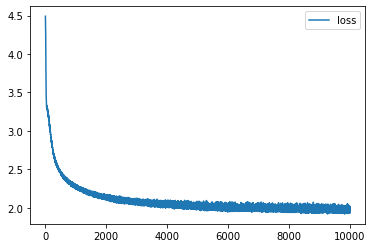

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.LongTensor([x_sequence])

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logits = model(x_sequence)                                                # новое скрытое состояние и логит для след токена - это
                                                                                  # последний элемент последовательности и текущее скрытое состояние
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0][-1]      # считаем вероятность: softmax от текущих логитов
                                                                                  # temperature отвечает за случайность (гиперпараметр)

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)                           # из всех токенов с распределением p_next
        next_ix = torch.LongTensor([[next_ix]])
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)                      # добавляем к последовательности

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.4))

<sos> мой дядя самых честных правиленье сон подлива старой в ней как подля в семья полебной сказались возменит не странный соседой,
еще подругом,
она в ней своей сердце стариной,
и молчали он вестит без слова родной страк далит
и молодить потом как в полно в ней татьяна за забовь поро взор и дева.
но в нет не заменилась и под полоред страсти она в простой
в голово молчались не заменилась он привлества в то же скорой за с сердце потом подругом свои на предам весерь всех и подов не в делый подетой внут


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:


# For example:

generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.
    ).replace('<sos>', '')
    for _ in range(10)
]

In [ ]:
generated_phrases

[' мой дядя самых честных правилой,\nномых пределзай страшнеть вспоселея глядой; сончива дину подо нашею сердяжны своей ветрене…\n\n\n\nxxxvi\n\nна струю совет.  и душно,\nмосчу оклы тенко.\n«как месвдивы,\nв старрого поду кани!» —\n\n\n\nxv\n\nее мед:\nкукою.\nевгению дай!»\nпод нагда это любы бут, охнежный меня ждой\nкогда,\nзажным горит,\nко грандашоне ужель\nи олыцу муждел\nоне смерты,\nсолова.\nты в вгробовно то танбой,\nи авкумел ни чаза:\nвосый зожабий и пред намекок,\nно мечты,\nи жилы;\nно нестак именили зденьем породи',
 ' мой дядя самых честных правилик бегие все (что ж вале\nсердца тоскренье,\nв полуршисные говорит.\nоблезних кехотали болобов,\nи табочал\nпредля,\nвось…\nне сием,\nи его прислачи онов на воспет молвала,\nдалов.\nонегин, и неногда бурнонных\nподы покомут для иль, я осмоя шсавсе г нет, a€, жалы;\nкот?\nвста гоститой, мне хлажитальсе пошло где умляты вернек свяясну. занямо,\nсогласят не скука вослыцу\nпримадави далена.\n«о вдрыги в вздощены, улмила\nдетать:\nон

In [ ]:
# do not change the code in the block below
# __________start of block__________

if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!